# Prequisites and Preprocessing

### Step IC1: Import necessary libraries and setup session

In [1]:
%%time
import boto3
import re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import session

project_name="caltech101" # maximum 17 characters

sess = session.Session()
bucket = sess.default_bucket()
s3_project_folder = project_name

role = get_execution_role()
training_image = get_image_uri(boto3.Session().region_name, 'image-classification')

CPU times: user 1.17 s, sys: 1.22 s, total: 2.39 s
Wall time: 1min 1s


In [2]:
# Change the download destination path if needed
!curl -o caltech.tar.gz http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  125M  100  125M    0     0  9042k      0  0:00:14  0:00:14 --:--:-- 10.1M


***Unzip the data***    
We would reduce the number of categories from 101 to 5 for this lab

In [15]:
!tar -xvf caltech.tar.gz 101_ObjectCategories/airplanes
!tar -xvf caltech.tar.gz 101_ObjectCategories/chair
!tar -xvf caltech.tar.gz 101_ObjectCategories/cup
!tar -xvf caltech.tar.gz 101_ObjectCategories/watch
!tar -xvf caltech.tar.gz 101_ObjectCategories/laptop

101_ObjectCategories/airplanes/
101_ObjectCategories/airplanes/image_0004.jpg
101_ObjectCategories/airplanes/image_0005.jpg
101_ObjectCategories/airplanes/image_0006.jpg
101_ObjectCategories/airplanes/image_0007.jpg
101_ObjectCategories/airplanes/image_0008.jpg
101_ObjectCategories/airplanes/image_0010.jpg
101_ObjectCategories/airplanes/image_0011.jpg
101_ObjectCategories/airplanes/image_0012.jpg
101_ObjectCategories/airplanes/image_0013.jpg
101_ObjectCategories/airplanes/image_0014.jpg
101_ObjectCategories/airplanes/image_0016.jpg
101_ObjectCategories/airplanes/image_0017.jpg
101_ObjectCategories/airplanes/image_0018.jpg
101_ObjectCategories/airplanes/image_0019.jpg
101_ObjectCategories/airplanes/image_0020.jpg
101_ObjectCategories/airplanes/image_0022.jpg
101_ObjectCategories/airplanes/image_0023.jpg
101_ObjectCategories/airplanes/image_0024.jpg
101_ObjectCategories/airplanes/image_0025.jpg
101_ObjectCategories/airplanes/image_0026.jpg
101_ObjectCategories/airplanes/image_0028.jpg
10

101_ObjectCategories/airplanes/image_0632.jpg
101_ObjectCategories/airplanes/image_0638.jpg
101_ObjectCategories/airplanes/image_0644.jpg
101_ObjectCategories/airplanes/image_0650.jpg
101_ObjectCategories/airplanes/image_0656.jpg
101_ObjectCategories/airplanes/image_0662.jpg
101_ObjectCategories/airplanes/image_0668.jpg
101_ObjectCategories/airplanes/image_0674.jpg
101_ObjectCategories/airplanes/image_0680.jpg
101_ObjectCategories/airplanes/image_0686.jpg
101_ObjectCategories/airplanes/image_0692.jpg
101_ObjectCategories/airplanes/image_0698.jpg
101_ObjectCategories/airplanes/image_0704.jpg
101_ObjectCategories/airplanes/image_0710.jpg
101_ObjectCategories/airplanes/image_0716.jpg
101_ObjectCategories/airplanes/image_0722.jpg
101_ObjectCategories/airplanes/image_0728.jpg
101_ObjectCategories/airplanes/image_0734.jpg
101_ObjectCategories/airplanes/image_0740.jpg
101_ObjectCategories/airplanes/image_0746.jpg
101_ObjectCategories/airplanes/image_0752.jpg
101_ObjectCategories/airplanes/ima

101_ObjectCategories/watch/image_0213.jpg
101_ObjectCategories/watch/image_0214.jpg
101_ObjectCategories/watch/image_0215.jpg
101_ObjectCategories/watch/image_0216.jpg
101_ObjectCategories/watch/image_0217.jpg
101_ObjectCategories/watch/image_0219.jpg
101_ObjectCategories/watch/image_0220.jpg
101_ObjectCategories/watch/image_0221.jpg
101_ObjectCategories/watch/image_0222.jpg
101_ObjectCategories/watch/image_0223.jpg
101_ObjectCategories/watch/image_0225.jpg
101_ObjectCategories/watch/image_0226.jpg
101_ObjectCategories/watch/image_0227.jpg
101_ObjectCategories/watch/image_0228.jpg
101_ObjectCategories/watch/image_0229.jpg
101_ObjectCategories/watch/image_0231.jpg
101_ObjectCategories/watch/image_0232.jpg
101_ObjectCategories/watch/image_0233.jpg
101_ObjectCategories/watch/image_0234.jpg
101_ObjectCategories/watch/image_0235.jpg
101_ObjectCategories/watch/image_0237.jpg
101_ObjectCategories/watch/image_0238.jpg
101_ObjectCategories/watch/image_0239.jpg
101_ObjectCategories/watch/image_0

### Step IC3: Build train and validation set

***Define the train and validation set, also how many percents of images should be allocated to validation set***

In [16]:
train_set = []
validation_set = []
validation_percentage = 0.20

***Shuffle data and generate train data set and validation data set***

In [17]:
import os
from random import shuffle
            
def move_percentage(list_a, percentage):
    shuffle(list_a)
    count = int(len(list_a) * percentage)
    if not count: return []  # edge case, no elements removed
    list_a[-count:], list_b = [], list_a[-count:]
    return list_b

path = "{}/101_ObjectCategories".format(os.getcwd())
categories = os.listdir(path)
categories = list(filter(lambda x: (not x.startswith('.') and not x.endswith('.lst')) ,categories))

category_index = 0
for c in categories:
    p = "{}/{}".format(path,c)
    files = os.listdir(p)
    for f in files:
        item = {
            'label': category_index,
            'file_name': f
        }
        train_set.append(item)
    category_index = category_index + 1

validation_set = move_percentage(train_set, validation_percentage)
print("There are {} of images in training data set".format(len(train_set)))
print("There are {} of images in validation data set".format(len(validation_set)))

There are 992 of images in training data set
There are 247 of images in validation data set


### Step IC4: Generate list file to be used by training algorithm 
Each row in list file correspond to 1 image data, with 3 columns: index, label, and file name

In [18]:
import os

train_lst_path = "{}/train.lst".format(path)
if os.path.exists(train_lst_path):
  os.remove(train_lst_path)
f = open("{}/train.lst".format(path), "a")
index = 1
for i in train_set:
    f.write("{}\t{}\t{}-{}".format(index, i['label'],categories[int(i['label'])],i['file_name']))
    index = index + 1
    if index <= len(train_set):
        f.write("\n")

f.close()
print("List file for train_set generated. First 10 lines:")
!head $train_lst_path

validation_lst_path = "{}/validation.lst".format(path)
if os.path.exists(validation_lst_path):
  os.remove(validation_lst_path)
f = open("{}/validation.lst".format(path), "a")
index = 1
for i in validation_set:
    f.write("{}\t{}\t{}-{}".format(index, i['label'],categories[int(i['label'])],i['file_name']))
    index = index + 1
    if index <= len(validation_set):
        f.write("\n")
        
f.close()
print("\n\nList file for validation_set generated. First 10 lines:")
!head $validation_lst_path


List file for train_set generated. First 10 lines:
1	1	watch-image_0110.jpg
2	0	airplanes-image_0764.jpg
3	0	airplanes-image_0278.jpg
4	0	airplanes-image_0284.jpg
5	0	airplanes-image_0707.jpg
6	1	watch-image_0074.jpg
7	0	airplanes-image_0480.jpg
8	0	airplanes-image_0579.jpg
9	4	chair-image_0019.jpg
10	2	cup-image_0046.jpg


List file for validation_set generated. First 10 lines:
1	1	watch-image_0170.jpg
2	0	airplanes-image_0568.jpg
3	0	airplanes-image_0233.jpg
4	0	airplanes-image_0105.jpg
5	0	airplanes-image_0680.jpg
6	0	airplanes-image_0223.jpg
7	0	airplanes-image_0517.jpg
8	0	airplanes-image_0252.jpg
9	0	airplanes-image_0032.jpg
10	1	watch-image_0051.jpg


### Step IC5: Upload to S3

In [19]:
import os 
import boto3
        
def upload_to_s3(channel, file, name):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + name
    s3.Bucket(bucket).put_object(Key=key, Body=data)

s3_train_path = "{}/train".format(s3_project_folder)
s3_validation_path = "{}/validation".format(s3_project_folder)
s3_lst_path = s3_project_folder

upload_to_s3(s3_lst_path, train_lst_path, 'train.lst')
upload_to_s3(s3_lst_path, validation_lst_path, 'validation.lst')

index=0
modulus=round(0.05*(len(train_set)+len(validation_set)))
for i in train_set:
    upload_to_s3(
        channel=s3_train_path, 
        file="{}/{}/{}".format(path,categories[int(i['label'])],i['file_name']),
        name="{}-{}".format(categories[int(i['label'])], i['file_name'])
    )
    if not index%modulus:
        print("Uploading: {} %".format(round(index/(len(train_set)+len(validation_set))*100)))
    index = index + 1
for i in validation_set:
    upload_to_s3(
        channel=s3_validation_path, 
        file="{}/{}/{}".format(path,categories[int(i['label'])],i['file_name']),
        name="{}-{}".format(categories[int(i['label'])], i['file_name'])
    )
    if not index%modulus:
        print("Uploading: {} %".format(round(index/(len(train_set)+len(validation_set))*100)))
    index = index + 1

print("Finished")

Uploading: 0 %
Uploading: 5 %
Uploading: 10 %
Uploading: 15 %
Uploading: 20 %
Uploading: 25 %
Uploading: 30 %
Uploading: 35 %
Uploading: 40 %
Uploading: 45 %
Uploading: 50 %
Uploading: 55 %
Uploading: 60 %
Uploading: 65 %
Uploading: 70 %
Uploading: 75 %
Uploading: 80 %
Uploading: 85 %
Uploading: 90 %
Uploading: 95 %
Finished


# Training the model

We are going to train the model with SageMaker. However, instead of creating 1 training job, we can create multiple training jobs with Hyperparameter Tuning feature. The purpose is to allow the multiple traning jobs with different hyperparameter values to be tried out, seeking for the best training job with best validation accuracy.

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Input specification**: These are the training and validation channels that specify the path where training data is present. These are specified in the "InputDataConfig" section. The main parameters that need to be set is the "ContentType" which can be set to "rec" or "lst" based on the input data format and the S3Uri which specifies the bucket and the folder where the data is present. 
* **Output specification**: This is specified in the "OutputDataConfig" section. We just need to specify the path where the output can be stored after training
* **Resource config**: This section specifies the type of instance on which to run the training and the number of hosts used for training. If "InstanceCount" is more than 1, then training can be run in a distributed manner. 

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 101 in this samples but other values such as 50, 152 can be used. 
* **num_training_samples**: This is the total number of training samples.
* **num_classes**: This is the number of output classes for the new dataset.
* **epochs**: Number of training epochs
* **learning_rate**: Learning rate for training
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run
* **use_pretrained_model**: Whether to use pretrained model that should be able to recognize some features of the images. We will use this to avoid our machine learning model to learn to understand image from 0.
* **optimizer**: Which optimizer to use in the training

### Step IC6: Setup training parameters
Run the training using Amazon sagemaker CreateHyperParameterTuningJob API

In [36]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = 18 
# we need to specify the input image shape for the training data
image_shape = "3,150,150"
# we also need to specify the number of training samples in the training set
num_training_samples = len(train_set)
# specify the number of output classes
num_classes = len(categories)
# training mini batch size range to be tuned
mini_batch_size_min = 20
mini_batch_size_max = 35
# number of epochs
epochs = 50
# learning rate range to be tuned
learning_rate_min = "0.001"
learning_rate_max = "0.05"
# maximum number of training jobs
hpo_max_number_of_training_jobs = 12
# maximum number of parallel training jobs
hpo_max_number_of_parallel_jobs = 1
# optimizers to be tried out in hyperparameter tuning
optimizers = ['sgd', 'rmsprop']
top_k = '2'
resize = 150
use_pretrained_model = 1

### Step IC7: Run training jobs with automatic hyperparameter tuning
Use SageMaker's Image Classification built-in algorithm to run the training job

In [37]:
%%time
import time
import boto3
from time import gmtime, strftime
from sagemaker import session, estimator
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner 

s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = s3_project_folder
timestamp = time.strftime('-%Y%m%d-%H%M%S', time.gmtime())
job_name = job_name_prefix + timestamp

# define the SageMaker training resources
imageclassification = estimator.Estimator(training_image, 
                                                    role, 
                                                    train_instance_count=1,
                                                    train_instance_type='ml.p2.xlarge',
                                                    output_path='s3://{}/{}/output'.format(bucket, job_name_prefix), 
                                                    sagemaker_session=sess)

# define data input channels in S3
train_channel = session.s3_input("s3://{}/{}".format(bucket,s3_train_path), distribution='FullyReplicated', s3_data_type='S3Prefix', input_mode='File', content_type='application/x-image')
validation_channel = session.s3_input("s3://{}/{}".format(bucket,s3_validation_path), distribution='FullyReplicated', s3_data_type='S3Prefix', input_mode='File', content_type='application/x-image')
train_lst_channel = session.s3_input("s3://{}/{}/train.lst".format(bucket,s3_lst_path), distribution='FullyReplicated', s3_data_type='S3Prefix', input_mode='File', content_type='application/x-image')
validation_lst_channel = session.s3_input("s3://{}/{}/validation.lst".format(bucket,s3_lst_path), distribution='FullyReplicated', s3_data_type='S3Prefix', input_mode='File', content_type='application/x-image')

# set the training static hyperparameters
imageclassification.set_hyperparameters(num_layers=num_layers, 
                                        image_shape=image_shape,
                                        num_classes=num_classes, 
                                        epochs=epochs, 
                                        resize=resize,
                                        top_k=top_k,
                                        use_pretrained_model=use_pretrained_model,
                                        num_training_samples=num_training_samples,  
                                        precision_dtype='float32')

# set the parameters for hyperparameter tuning job
hpo_objective_metric_name = 'validation:accuracy'
hpo_hyperparameter_ranges = \
{
    'learning_rate': ContinuousParameter(learning_rate_min, learning_rate_max),
    'mini_batch_size': IntegerParameter(mini_batch_size_min, mini_batch_size_max),
    'optimizer': CategoricalParameter(optimizers)
}

tuner_es = HyperparameterTuner(imageclassification, 
                               hpo_objective_metric_name, 
                               hpo_hyperparameter_ranges,
                               objective_type='Maximize', 
                               max_jobs=hpo_max_number_of_training_jobs, 
                               max_parallel_jobs=hpo_max_number_of_parallel_jobs, 
                               early_stopping_type='Auto')

# run the hyperparameter tuning job
tuner_es.fit({
    'train': train_channel,
    'validation': validation_channel, 
    'train_lst': train_lst_channel,
    'validation_lst': validation_lst_channel
}, job_name=job_name, include_cls_metadata=False)

print('Hyperparameter Tuning job name: {}'.format(job_name))

Hyperparameter Tuning job name: caltech101-20190619-141706
CPU times: user 16.9 ms, sys: 0 ns, total: 16.9 ms
Wall time: 380 ms


***Continuously check training job status wait until the job completes***

In [47]:
tuner_es.wait()

!


### Step IC8: Analyze result, pick best training, and createlabel file

***List the top 5 hyperparameters***

In [48]:
from sagemaker import HyperparameterTuningJobAnalytics
tuner_metrics_es = HyperparameterTuningJobAnalytics(job_name)
tuner_metrics_es.dataframe().sort_values(['FinalObjectiveValue'], ascending=False).head(5)

FinalObjectiveValue  TrainingElapsedTimeSeconds           TrainingEndTime  \
1              0.996000                       386.0 2019-06-19 16:09:55+00:00   
2              0.996000                       413.0 2019-06-19 15:59:20+00:00   
0              0.995885                       404.0 2019-06-19 16:20:11+00:00   
11             0.995885                       405.0 2019-06-19 14:26:45+00:00   
3              0.995833                       439.0 2019-06-19 15:49:08+00:00   

                            TrainingJobName TrainingJobStatus  \
1   caltech101-20190619-141706-011-cc8801ca         Completed   
2   caltech101-20190619-141706-010-cce6d107         Completed   
0   caltech101-20190619-141706-012-425dbf72         Completed   
11  caltech101-20190619-141706-001-df606a0a         Completed   
3   caltech101-20190619-141706-009-6c17eae5         Completed   

           TrainingStartTime  learning_rate  mini_batch_size optimizer  
1  2019-06-19 16:03:29+00:00       0.020394             25.0       sgd  
2  2019-06-19 15:52:27+00:00       0.008437             25.0       sgd  
0  2019-06-19 16:13:27+00:00       0.014586             27.0       sgd  
11 2019-06-19 14:20:00+00:00       0.022825             27.0       sgd  
3  2019-06-19 15:41:49+00:00       0.007755             20.0       sgd

***Pick best training job***

In [49]:
best_training_job_name = tuner_es.best_training_job()

**Enrich the model file with class labels and remove unnecessary file**

In [95]:
synset_content = "{"
i=0
for c in categories:
    synset_content += "'{}':'{}'".format(i,c)
    i += 1
    if(i < len(categories)):
        synset_content += ","
synset_content += "}"

import os
path = "{}/model_content".format(os.getcwd())
if not os.path.exists(path):
    os.makedirs(path)
    
s3c = boto3.client('s3')
s3c.download_file(bucket, info['ModelArtifacts']['S3ModelArtifacts'].split("s3://" + bucket + "/")[1], 'model.tar.gz')
!mv model.tar.gz ./model_content/
!tar -xvf ./model_content/model.tar.gz -C ./model_content
!rm ./model_content/model.tar.gz


image-classification-symbol.json
image-classification-0003.params
synset.txt


In [96]:
!rm ./model_content/model-shapes.json

rm: cannot remove ‘./model_content/model-shapes.json’: No such file or directory


In [97]:
!touch ./model_content/synset.txt
f = open("./model_content/synset.txt", "w")
f.write(synset_content)
f.close()

In [98]:
!tar -czvf ./model_content/model.tar.gz ./model_content/*

./model_content/image-classification-0003.params
./model_content/image-classification-symbol.json
./model_content/synset.txt


In [99]:
s3c.upload_file('./model_content/model.tar.gz', bucket, info['ModelArtifacts']['S3ModelArtifacts'].split("s3://" + bucket + "/")[1])

# Deploy The Model

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the topic mixture representing a given document.

## Step IC9: Create model

We now create a SageMaker Model from the training output. Using the model we can create a Batch Transform Job or an Endpoint Configuration.

In [ ]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

model_name=project_name
print(model_name)
info = sage.describe_training_job(TrainingJobName=best_training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

# Realtime inference

We now host the model with an endpoint and perform realtime inference.

### Step IC10: Create Endpoint Configuration
At launch, we will support configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way.

In addition, the endpoint configuration describes the instance type required for model deployment, and at launch will describe the autoscaling configuration.

In [ ]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

### Step IC11: Create Endpoint
Creates the endpoint that serves up the model. The end result is an endpoint that can be validated and incorporated into production applications.

In [ ]:
%%time
import time
import boto3

sagemaker = boto3.client('sagemaker')

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

***Continuously check whether the endpoint has been successfully created***

In [50]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = InService
Endpoint creation ended with EndpointStatus = InService


If you see the message,

> `Endpoint creation ended with EndpointStatus = InService`

then congratulations! You now have a functioning inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console.

### Step IC12: Prepare upload directory


***First make the direcctory for test data upload***

In [51]:
import os
path = "{}/test-images".format(os.getcwd())
if not os.path.exists(path):
    os.makedirs(path)

### Step IC13: Upload test data

**IMPORTANT:**   
***Please upload several (e.g. 10) images to /test-images folder in this Jupyter Notebook***

***Display image***

In [52]:
from IPython.display import HTML
import os

test_images = os.listdir(path)
display_string = ''
for im in test_images:
    file_name = "{}/{}".format('./test-images',im)
    display_string += '<figure style="float:left;"><img src="{}" alt="{}" width="200"/><figcaption ><center>{}</center></figcaption></figure>'.format(file_name, im, im)

HTML(data=display_string)
    

### Step IC13: Perform evaluation

Evaluate the images through the network for inteference for every images uploaded to /test-data folder

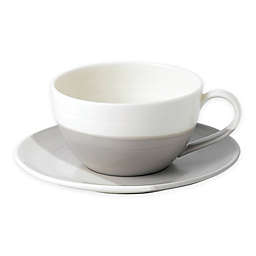

File name: cup.jpg Result: label - cup with confidence 0.99986732006073




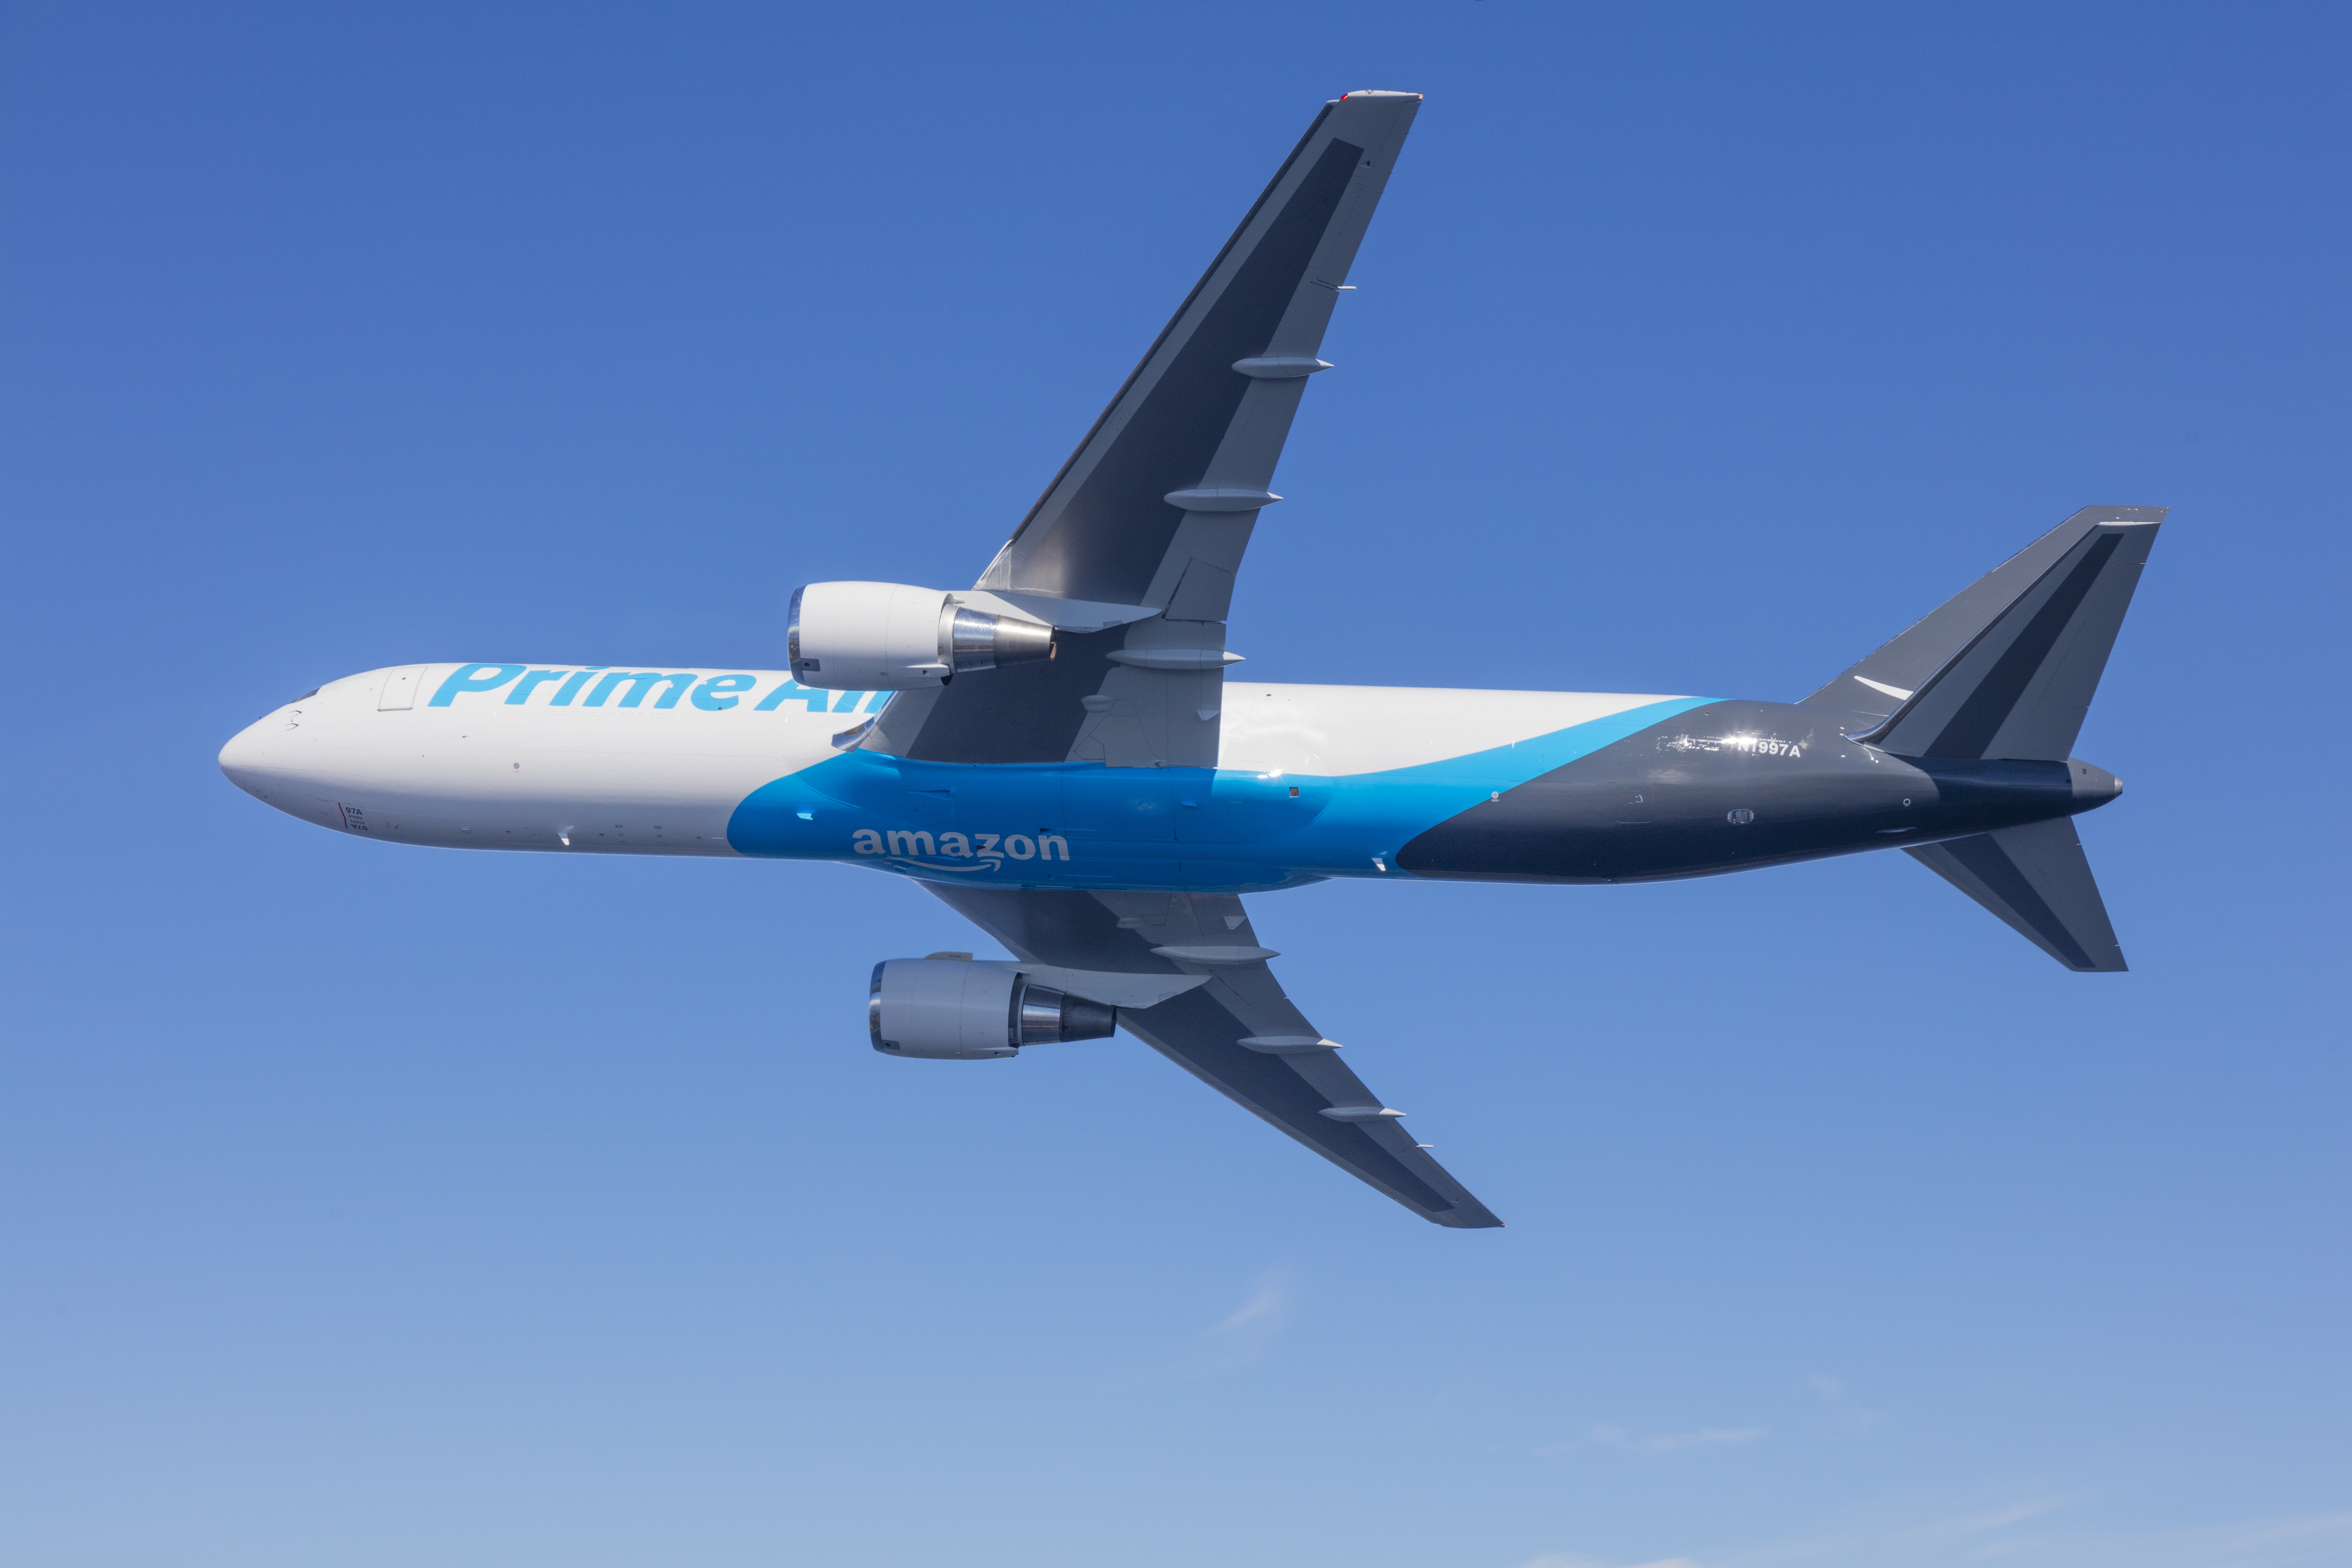

File name: airplane.JPG Result: label - airplanes with confidence 0.9990725517272949




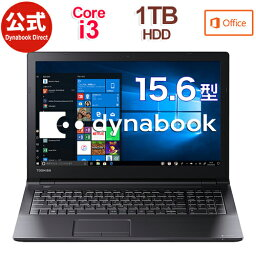

File name: laptop.jpg Result: label - laptop with confidence 0.95624840259552




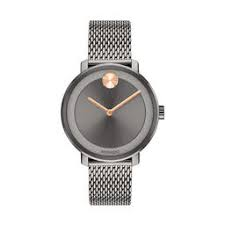

File name: watch.jpg Result: label - watch with confidence 0.6770281791687012




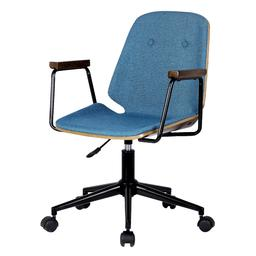

File name: chair.jpg Result: label - chair with confidence 0.9990023970603943




In [53]:
import boto3
import json
import numpy as np
from IPython.display import Image

runtime = boto3.Session().client(service_name='runtime.sagemaker')

for im in test_images:
    file_name = "{}/{}".format(path,im)
    with open(file_name, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)
    response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                       ContentType='application/x-image', 
                                       Body=payload)
    result = response['Body'].read()
    # result will be in json format and convert it to ndarray
    result = json.loads(result)
    # the result will output the probabilities for all classes
    # find the class with maximum probability and print the class index
    index = np.argmax(result)
    display(Image("./test-images/{}".format(im)))
    print("File name: {} Result: label - {} with confidence {}\n\n".format(im, categories[index], str(result[index])))

### Step IC15: Clean up (Optional) 

If you are using this notebook only for trial/experiment, you might want to delete the Sagemaker Endpoint created to avoid cost.

In [33]:
sage.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '59b0f6c5-b4c3-4a85-bee8-6a6fa6300993',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '59b0f6c5-b4c3-4a85-bee8-6a6fa6300993',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 19 Jun 2019 13:47:44 GMT'},
  'RetryAttempts': 0}}

***Delete images source and model output in S3 (Optional)***

In [ ]:
import boto3
s3 = boto3.client('s3')
s3_objects = s3.list_objects(
    Bucket=bucket,
    Delimiter=',',
    EncodingType='url',
    MaxKeys=5000,
    Prefix=project_name
)
to_be_deleted = list(map(lambda x: {'Key':x['Key']},s3_objects['Contents']))
s3.delete_objects(
    Bucket=bucket,
    Delete={
        'Objects': to_be_deleted,
        'Quiet': True
    }
)

***Clean up data in this Jupyter Notebook (Optional)***

In [ ]:
!rm -rf ./test-images